In [1]:
begin
	using Pkg
	Pkg.activate(".")
end

In [83]:
using Revise
using DeconvOptim, TestImages, ImageShow, Plots, LinearAlgebra, IndexFunArrays, Noise
using FourierTools, SpecialFunctions, FFTW, Images, Tullio, PlutoUI, Pluto, InteractiveUtils, PGFPlotsX

In [25]:
macro bind(def, element)
    quote
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : missing
        el
    end 
end

@bind (macro with 1 method)

In [4]:
begin
	img = Float32.(testimage("fabio_gray"));
	img_1D = img[:, 200]
end;

In [5]:
otf(x, Δx=1) = begin
	x = abs(x)
	if x <= Δx 
		SpecialFunctions.jinc(x * Δx *(1-x/Δx)) .* 2 / π * (acos(x/Δx) - x/Δx * sqrt(1-(x/Δx)^2))
	else
		zero(x)
	end
end

# ╔═╡ 9a07bc88-be76-4531-bc91-df0d20c3221c
begin
	x = range(-1.5, 1.5, length=size(img, 1))
	freqs = fftshift(fftfreq(size(img_1D, 1), 1))
	psf = Float32.(DeconvOptim.generate_psf(size(img), 20))
	psf_1D = psf[1, :]
	psf_1D ./= sum(psf_1D)
	otf_1D = abs.(ffts(psf_1D))
end;

In [6]:
img_n = Float32.(poisson(DeconvOptim.conv(img, psf), 1000));

# ╔═╡ 3bda922d-552b-42ec-9055-33a141b5841a
blur(x, otf=otf_1D) = iffts(ffts(x) .* otf)

blur (generic function with 2 methods)

In [72]:
otf(x, Δx=1) = begin
	x = abs(x)
	if x <= Δx 
		SpecialFunctions.jinc(x * Δx *(1-x/Δx)) .* 2 / π * (acos(x/Δx) - x/Δx * sqrt(1-(x/Δx)^2))
	else
		zero(x)
	end
end

# ╔═╡ 9a07bc88-be76-4531-bc91-df0d20c3221c
begin
	x = range(-1.5, 1.5, length=size(img, 1))
	freqs = fftshift(fftfreq(size(img_1D, 1), 1))
	psf = Float32.(DeconvOptim.generate_psf(size(img), 20))
	psf_1D = psf[1, :]
	psf_1D ./= sum(psf_1D)
	otf_1D = abs.(ffts(psf_1D))
end;

# ╔═╡ 24fc86da-0b7c-493c-8977-2a19ef6dc133
img_n = Float32.(poisson(DeconvOptim.conv(img, psf), 1000));

# ╔═╡ 3bda922d-552b-42ec-9055-33a141b5841a
blur(x, otf=otf_1D) = iffts(ffts(x) .* otf)



# ╔═╡ b542187a-3ae7-4430-a81d-f968d9000427
img_blurry = poisson(DeconvOptim.conv(img, psf), 200);

# ╔═╡ 88d83629-f1b2-4d69-928f-d4acfbc76b70
reg_1D = TV(num_dims=1);

# ╔═╡ d6d0f436-48fd-4e8a-863c-3e9d3850cc91
begin
	reg_tik = Tikhonov()
	reg_TV = TV()
	reg_GR = DeconvOptim.GR(ϵ=1f-4)
end



# ╔═╡ 49686d9a-1683-428f-83ba-a9131c2ad432
[Gray.(img) Gray.(DeconvOptim.conv(img, psf))]



# ╔═╡ b6f9e42e-5a23-40ad-9e73-8f02da48f69c


# ╔═╡ e31f4704-5bce-4c8d-b3a7-873a3460d9f8
plot(x, otf.(x), xlabel="frequency / maximum frequency", ylabel="contrast")

# ╔═╡ dc8cf4e2-a87c-47ea-8247-3ae772852241


# ╔═╡ f8033d13-faee-41f5-bdd6-ae8721e8b8a8
begin
	plot(freqs, abs.(ffts(img_blurry)[:, 128]), yaxis=:log, ylabel="real part of FFT output in AU", xlabel="frequency in 1/px", ylims=(1e-4, 1e2), label="blurred")
	plot!(freqs, abs.(ffts(img)[:, 128]), ylabel="abs of FFT output in AU", 
				xlabel="frequency in 1/px", yaxis=:log,
				ylims=(1e-4, 1e4), label="ground truth")
	#plot!(freqs, abs.(ffts(DeconvOptim.conv(img_1D, psf_1D))))
end


# ╔═╡ 90e5708c-05a4-46e4-b1e4-9a61c96dae32
TV_by_hand(x) = @tullio r = sqrt(1f-8 + abs2(x[i, j] - x[i+1, j]) + 
						 	     abs2(x[i, j] - x[i, j+1]))

# ╔═╡ 03139ac5-3525-4fad-abf1-84421492b763
DeconvOptim.generate_TV(4, [1,2, 3], [1,1, 1], 1, 0)[1]



# ╔═╡ 9d9a5da2-14df-46e6-b7e6-5a33aade1754
@bind reg_list2 Select(["1" => ("Tikhonov"), "2" => ("Total Variation TV"), "3" => ("Good's Roughness GR")])

# ╔═╡ 5ae1a6a3-4505-4123-9f1e-8a1d4ac0b4e1
reg = [reg_tik, reg_TV, reg_GR][parse(Int, reg_list2)]

# ╔═╡ 15d54e5e-64f4-4a1d-8cc8-9334b2e3784f

reg_bool = true

iter=30

λ = 0.05

# ╔═╡ 803368e6-53fd-4413-b3f5-ffe46ee8983e
img_deconv, res_img = deconvolution(img_blurry, psf, regularizer=reg, iterations=20, λ=λ);
img_deconv_reg, res_img = deconvolution(img_blurry, psf, regularizer=reg_GR, iterations=20, λ=λ);
img_deconv_nothing, res_img = deconvolution(img_blurry, psf, regularizer=nothing, iterations=20, λ=λ);

# ╔═╡ e58e1f63-2c81-48fb-866a-4bb70bd428a6
Gray.(img_deconv)

# ╔═╡ 438a6639-bd35-464f-a81d-d98eb65e006e
res_1D, o = deconvolution(real(blur(img_1D)), psf_1D, iterations=iter, regularizer=reg_1D, λ=0.01);


# ╔═╡ 7a16df73-95ad-47f5-907c-6fd23c6000cf
[Gray.(img) Gray.(img_blurry) Gray.(img_deconv)]

# ╔═╡ 5c8030b7-8805-4771-9329-23abb2744544
begin
	plot(freqs, abs.(ffts(img_blurry)[:, 128]), yaxis=:log, ylabel="abs of FFT output in AU", xlabel="frequency in 1/px", ylims=(1e-4, 1e2), label="blurred")
	plot!(freqs, abs.(ffts(img)[:, 128]),  yaxis=:log,
				ylims=(1e-4, 1e4), label="ground truth")
	plot!(freqs, abs.(ffts(img_deconv)[:, 128]), label="deconvolved image")
end

# ╔═╡ ff9af79c-f06c-42ac-9c8d-6f09d2ff4056
[Gray.(img_1D); Gray.(res_1D)];



In [82]:
save("../../paper/figures/fabio_blurry.png", img_blurry ./ maximum(img_blurry))
save("../../paper/figures/fabio_deconv_regularizer_005_iter_30.png", min.(1.0, img_deconv_reg))
save("../../paper/figures/fabio_deconv_no_reg_iter_30.png", img_deconv_nothing ./ maximum(img_deconv_nothing))

0

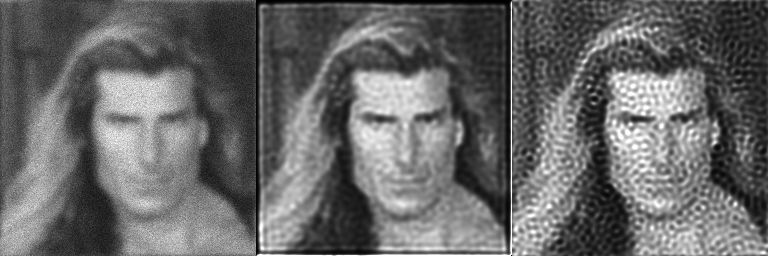

In [73]:
[Gray.(img_blurry) Gray.(img_deconv_reg) Gray.(img_deconv_nothing)] 

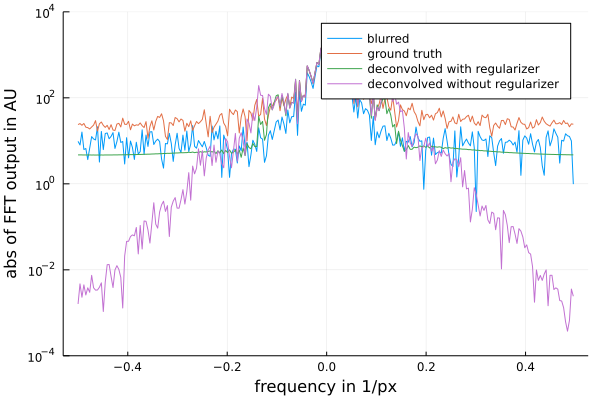

In [61]:
begin
	plot(freqs, abs.(ffts(img_blurry)[:, 128]), yaxis=:log, ylabel="abs of FFT output in AU", xlabel="frequency in 1/px", ylims=(1e-4, 1e2), label="blurred")
	plot!(freqs, abs.(ffts(img)[:, 128]),  yaxis=:log,
				ylims=(1e-4, 1e4), label="ground truth")
	plot!(freqs, abs.(ffts(img_deconv)[:, 128]), label="deconvolved with regularizer")
    plot!(freqs, abs.(ffts(img_deconv_nothing)[:, 128]), label="deconvolved without regularizer")
end

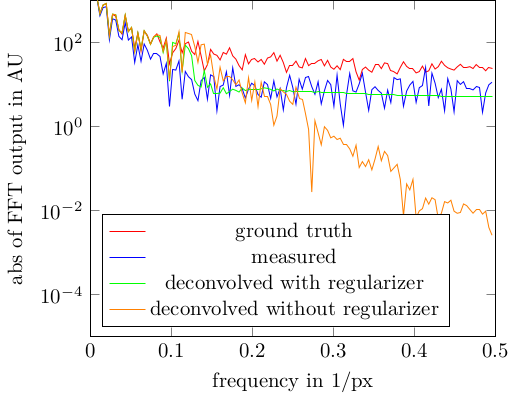

In [108]:
plt1 = @pgf PGFPlotsX.Axis(
    {xlabel="frequency in 1/px", ymode="log", ylabel="abs of FFT output in AU", xmin=0, xmax=0.5, ymin=0.00001, ymax=1000, 
        legend_pos="south west", legend_entries={"ground truth", "measured", "deconvolved with regularizer", "deconvolved without regularizer"}},
    Plot({"sharp plot", color="red"
        },
        Table([freqs, abs.(ffts(img)[:, 128])])
    ),
    
    Plot({"sharp plot", color="blue"
        },
        Table([freqs, abs.(ffts(img_blurry)[:, 128])])
    ),
    Plot({"sharp plot", color="green"
        },
        Table([freqs,  abs.(ffts(img_deconv)[:, 128])])
    ),

        Plot({"sharp plot", line_width="0.01cm", color="orange"
        },
        Table([freqs, abs.(ffts(img_deconv_nothing)[:, 128])])
    ),
)
pgfsave("../../paper/figures/frequencies_img.pdf", plt1)
plt1
